In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import random

In [2]:
from framework.image import SobelGradient
from framework.losses import MutualInformationLossNative, MutualInformationLossFPGA, MutualInformationLoss
from framework.optimizers import GradientDescentOptimizer
from framework.transforms import RotateShiftTransform

import pydicom
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [3]:
overlay = Overlay('./build/assets/mutual_information_gradient_matrix/gem_wrapper.bit')

In [4]:
mi_ip = overlay.mutual_information_derived_master_0

In [5]:
size = 512
image_dim = size*size
matrix_dim = 256*256
image_1 = allocate(shape=(image_dim,), dtype=np.uint8)
image_2 = allocate(shape=(image_dim,), dtype=np.uint8)
res = allocate(shape=(matrix_dim,), dtype=np.float32)

In [6]:
dcm1 = pydicom.dcmread('IM10_a.dcm')
img1 = cv2.resize(dcm1.pixel_array, dsize=(size,size))
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

dcm2 = pydicom.dcmread('IM10_b.dcm')
img2 = cv2.resize(dcm2.pixel_array, dsize=(size,size))
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [7]:
lr = 1e-3
alpha = 1e-6

transform = RotateShiftTransform(alpha=alpha)
grad = SobelGradient(k=3)
loss = MutualInformationLossFPGA(mi_ip, image_1, image_2, res)
optimizer = GradientDescentOptimizer(transform, loss, grad, lr, 1)

In [8]:
image_1[:] = img1.flatten()
image_1.flush()

In [9]:
for i in tqdm(range(30)):
    optimizer.step(img1, img2)  
final = optimizer.transform(img2)

100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


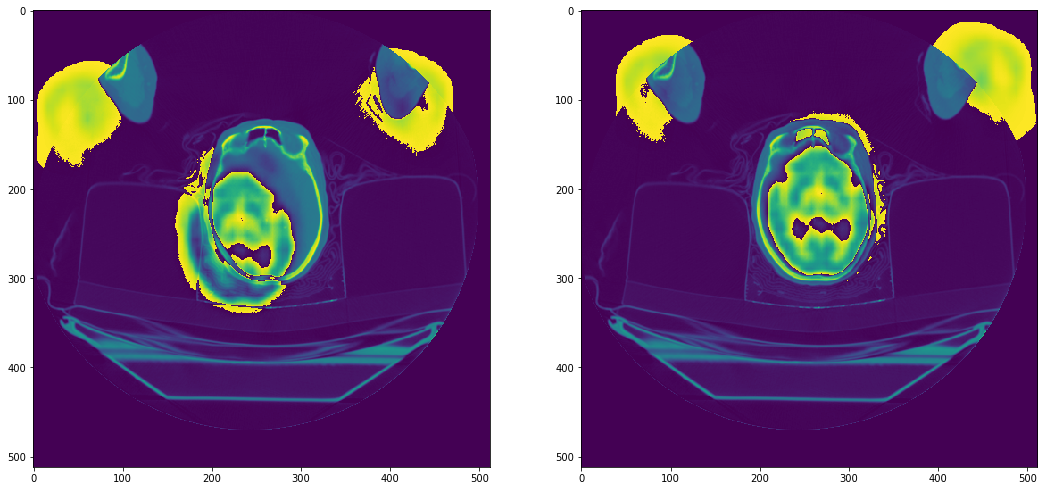

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)
ax[0].imshow(img1 - img2)
ax[1].imshow(img1 - final)